# **About the dataset**

**Context**

This dataset contains 4242 images of flowers.

The data collection is based on the data flicr, google images, yandex images.

**Content**

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

# **Import needed libraries**

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

2024-03-23 07:31:40.391543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 07:31:40.391632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 07:31:40.536216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading the dataset**
Read the dataset into the dataframe

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [3]:
# loading the data
data_dir = '/kaggle/input/flowers-recognition/flowers'
df = loading_the_data(data_dir)

df

filepaths     labels
0     /kaggle/input/flowers-recognition/flowers/dand...  dandelion
1     /kaggle/input/flowers-recognition/flowers/dand...  dandelion
2     /kaggle/input/flowers-recognition/flowers/dand...  dandelion
3     /kaggle/input/flowers-recognition/flowers/dand...  dandelion
4     /kaggle/input/flowers-recognition/flowers/dand...  dandelion
...                                                 ...        ...
4312  /kaggle/input/flowers-recognition/flowers/rose...       rose
4313  /kaggle/input/flowers-recognition/flowers/rose...       rose
4314  /kaggle/input/flowers-recognition/flowers/rose...       rose
4315  /kaggle/input/flowers-recognition/flowers/rose...       rose
4316  /kaggle/input/flowers-recognition/flowers/rose...       rose

[4317 rows x 2 columns]

# **Data preprocessing**
first we will check if the training data is balanced or not

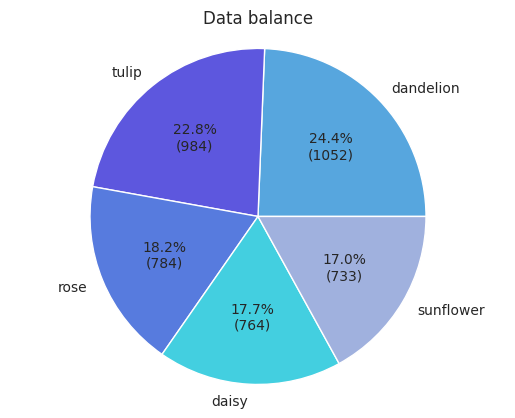

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#57A6DE","#5D57DE","#577BDE","#43CFE0","#A0B1DE"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

We can say that data is almost balanced.

Now we will split the dataset to train, val and test data.

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

In [6]:
batch_size = 16
img_size = (224, 224)

# Create generators for the data
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


# Convert the data
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 3453 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


**Display sample from train data**

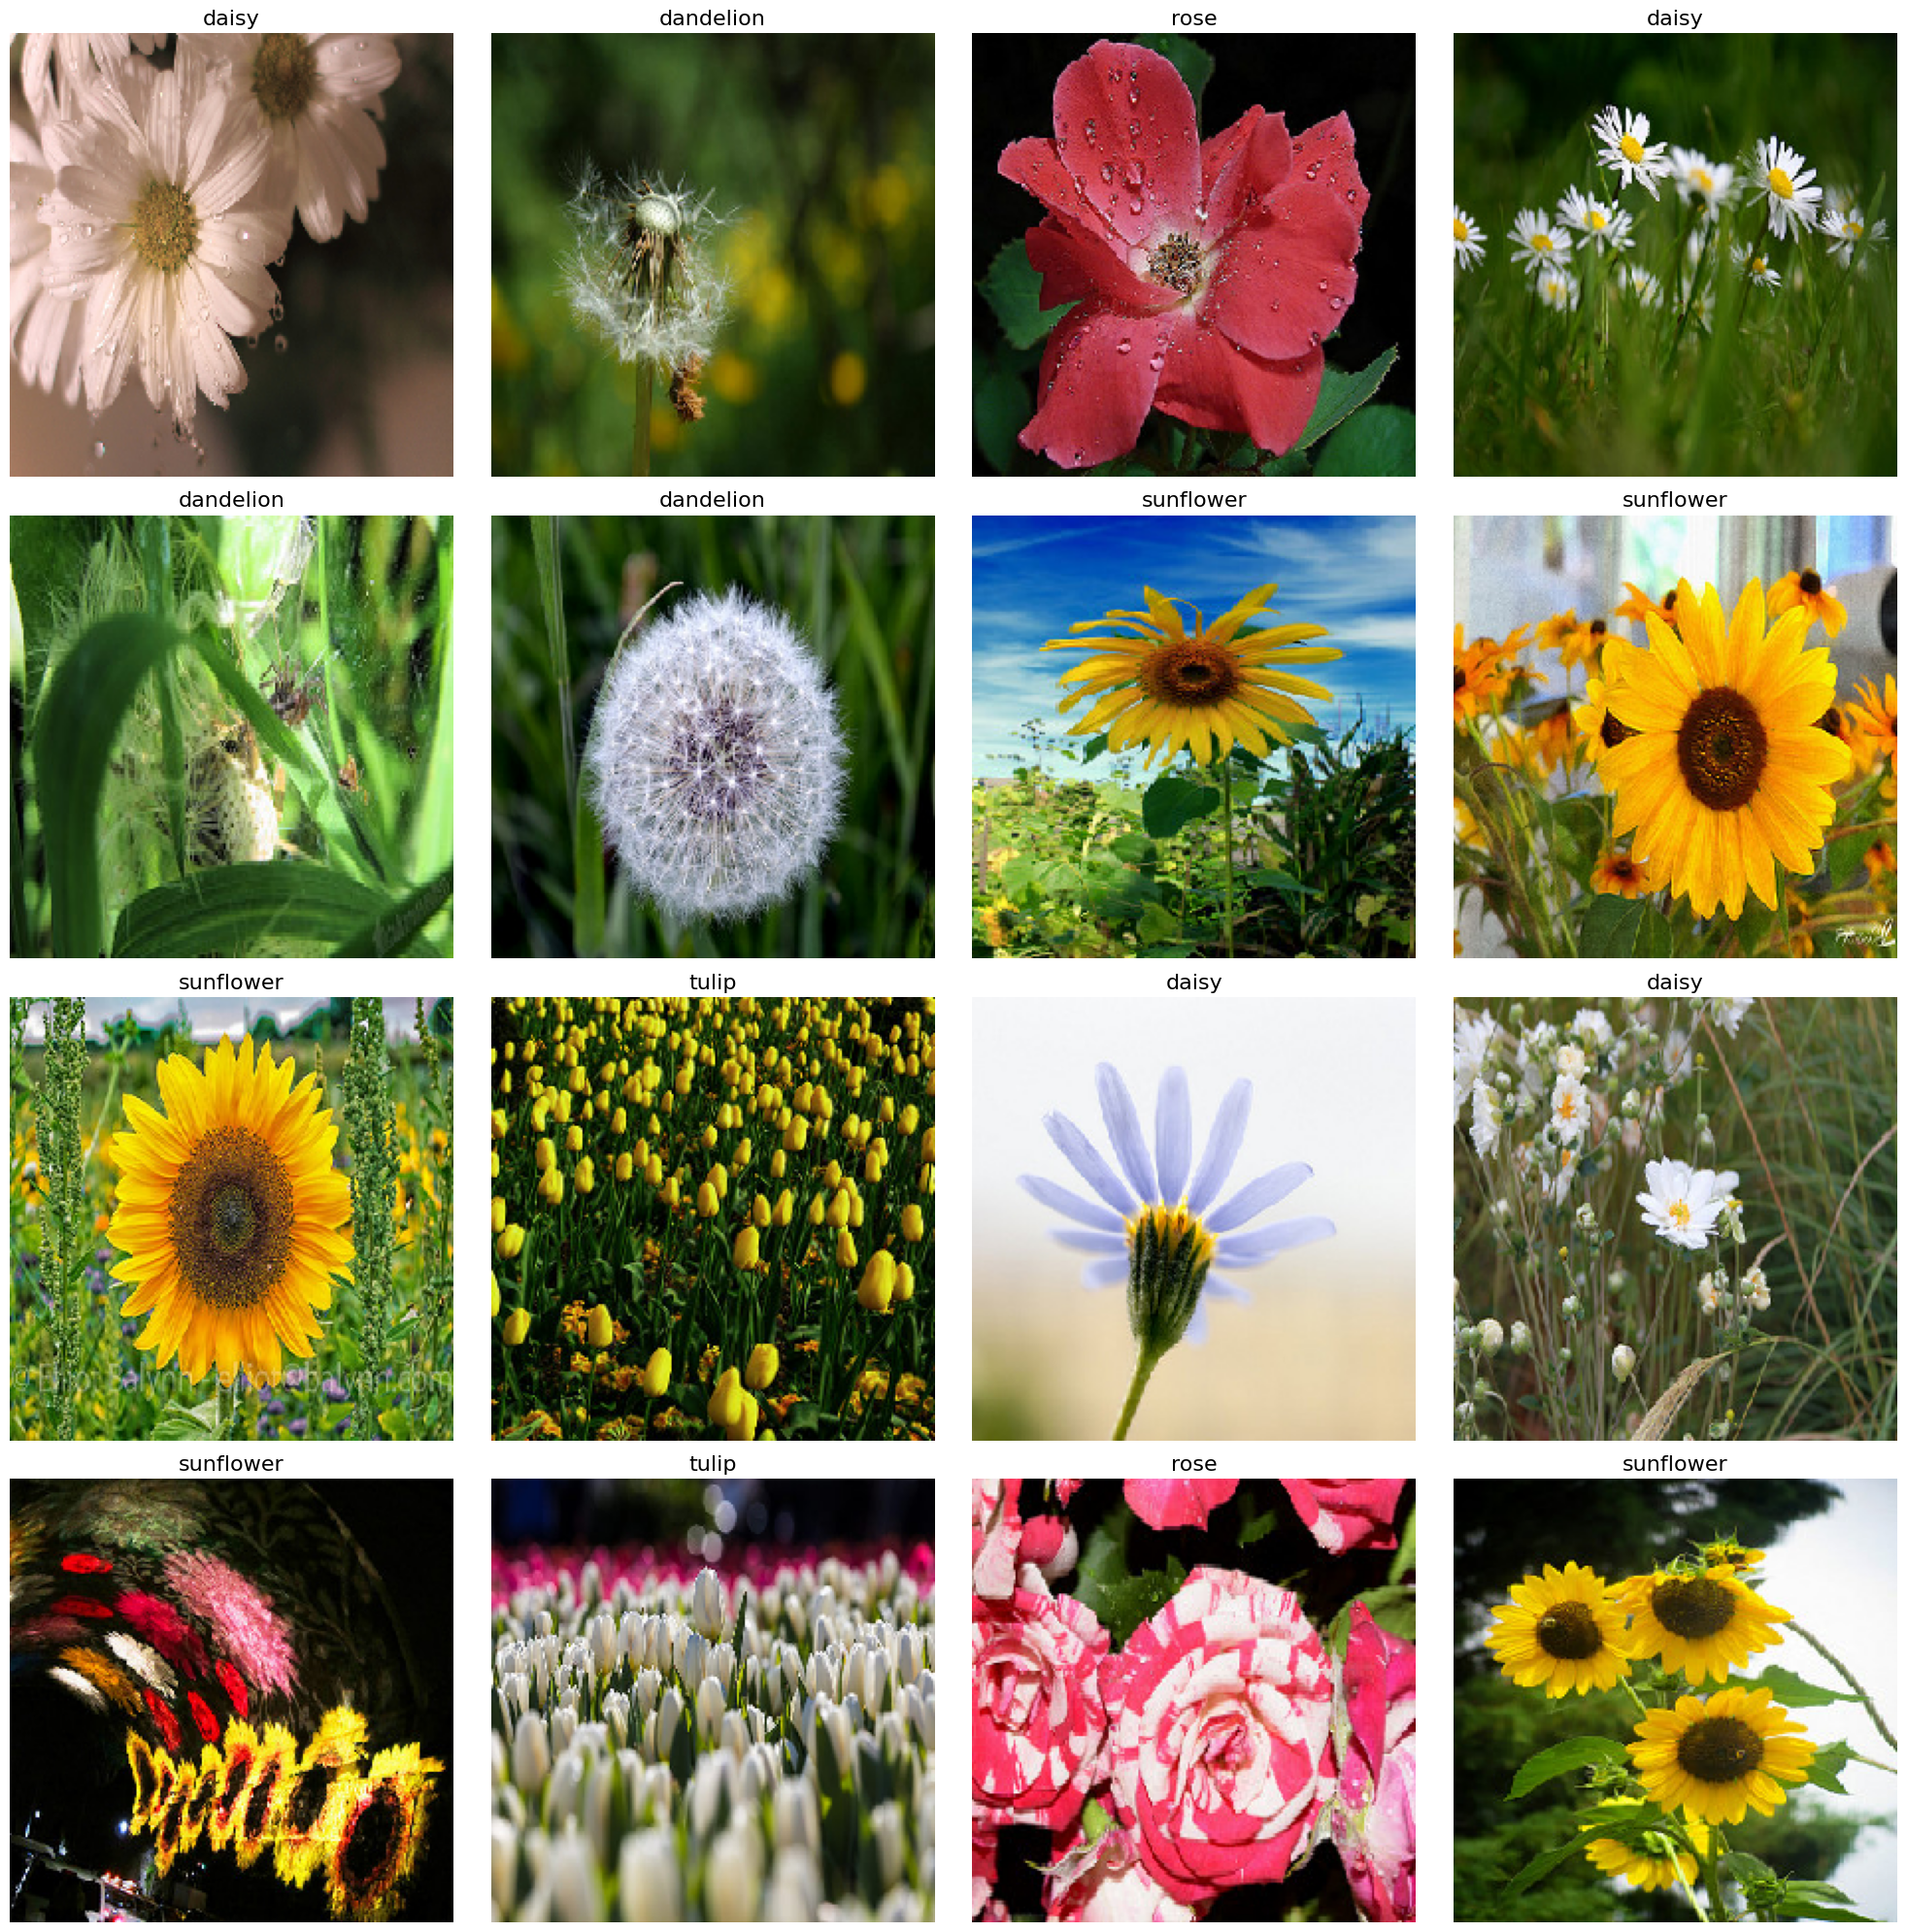

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [8]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# **Models Structures**

# **CNN model**

In [9]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [10]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# sixth conv block
cnn_model.add(conv_block(512))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(256, 0.5))

# second dense block
cnn_model.add(dense_block(128, 0.3))

# third dense block
cnn_model.add(dense_block(64, 0.2))

# fourth dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [11]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 3, 3, 512)      │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │     1,180,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,669 (22.68 MB)

 Trainable params: 5,942,693 (22.67 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [12]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  2/216 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.1719 - loss: 2.1634   

I0000 00:00:1711179148.524719      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711179148.554731      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2314 - loss: 2.0305

W0000 00:00:1711179189.248049      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711179190.666099      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - accuracy: 0.2315 - loss: 2.0301 - val_accuracy: 0.2778 - val_loss: 2.1656
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2853 - loss: 1.7949 - val_accuracy: 0.2616 - val_loss: 2.0961
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3299 - loss: 1.6160 - val_accuracy: 0.3611 - val_loss: 1.4216
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3775 - loss: 1.5033 - val_accuracy: 0.4815 - val_loss: 1.2746
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4012 - loss: 1.4271 - val_accuracy: 0.5532 - val_loss: 1.1323
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4437 - loss: 1.3337 - val_accuracy: 0.4907 - val_loss: 1.1766
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4856 - loss: 1.2305 - val_accuracy: 0.5949 - val_loss: 1.0530
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5314 - loss: 1.1473 - val_accura

**Display model performance**

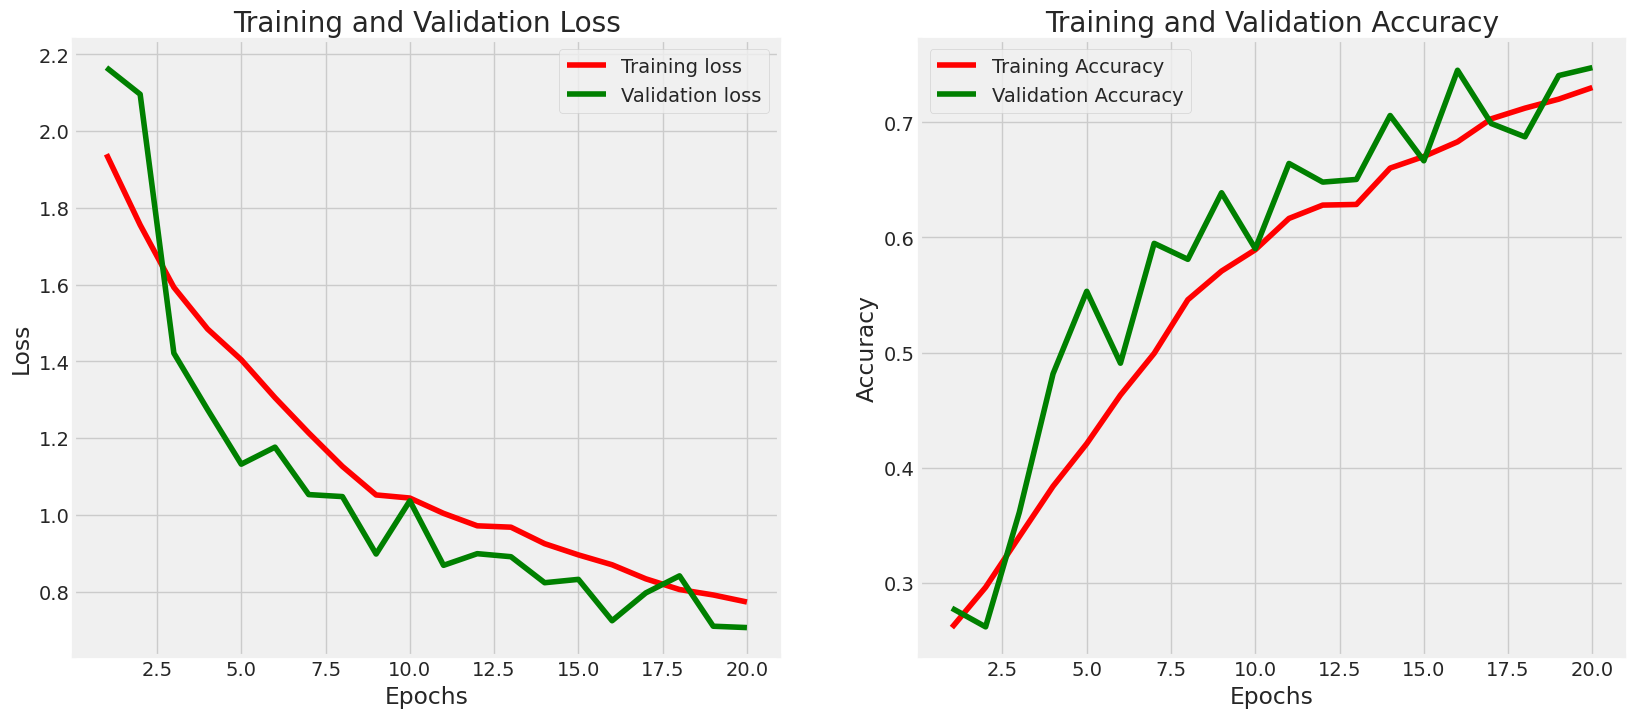

In [13]:
# Display model performance
model_performance(history, epochs)

**Evaluate the model**

In [14]:
# Model evaluation
model_evaluation(cnn_model)

216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8069 - loss: 0.5422
 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7031 - loss: 0.8605

W0000 00:00:1711179401.444606      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7146 - loss: 0.8100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7917 - loss: 0.5697
Train Loss:  0.5354670286178589
Train Accuracy:  0.80770343542099
--------------------
Validation Loss:  0.7064852714538574
Validation Accuracy:  0.7476851940155029
--------------------
Test Loss:  0.654822587966919
Test Accuracy:  0.7476851940155029


**Get predictions and display the confusion matrix**

 5/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

W0000 00:00:1711179408.163397      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


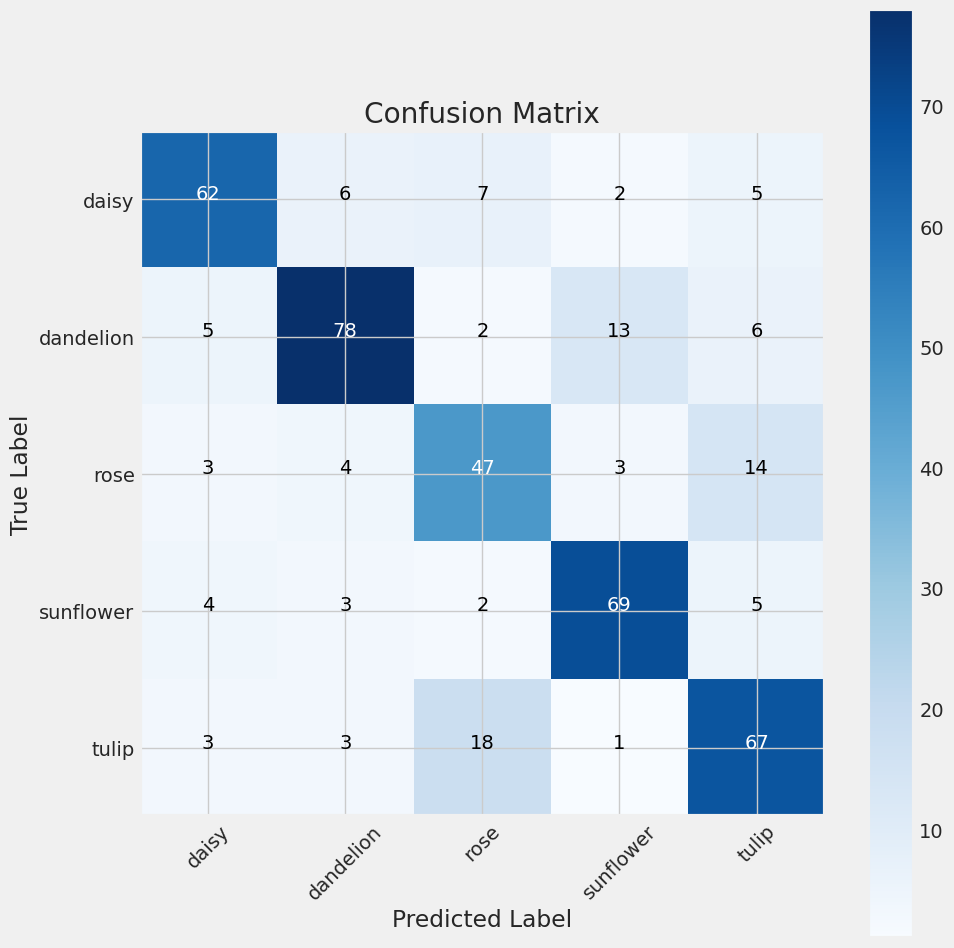

In [15]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)